<a href="https://colab.research.google.com/github/annabavaresco/cifar-10-soft-classification/blob/main/CIFAR_10_soft_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 soft labels

In [1]:
import torch
from torchvision.models import resnet18
from torch.optim.lr_scheduler import MultiStepLR
from torch.nn.functional import softmax
import math
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model

In [2]:
class SL(nn.Module):
    '''
    Resnet18 model with modified output layer
    '''
    def __init__(self, n_classes):
        super(SL, self).__init__()
        self.model = resnet18()
        self.model.fc = nn.Linear(in_features=512, out_features=n_classes, bias=True)
    
    def forward(self, x):

        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)
        embeddings = torch.flatten(x, 1)
        outputs = self.model.fc(embeddings)

        return embeddings, outputs

## Training function

In [3]:
def compute_soft_labels(embeddings, labels, T):

  n_images = labels.size(0)
  n_classes = 10
  sim_labels = torch.zeros((n_images, n_classes)).to(device)
  sim_mat = torch.corrcoef(embeddings)
  # sim_mat = torch.cdist(embeddings, embeddings)
  idxs = torch.arange(n_images).to(device)
  
  # getting similarity arrays
  
  for i in range(n_classes):
    mask = (torch.zeros((n_images, n_images))) == 1
    mask[:,labels==i] = True
    mask[idxs,idxs] = False
    mask = mask.to(device)
    red_mat = torch.where(mask==True, sim_mat, torch.zeros((n_images, n_images)).to(device))
    rowsum = red_mat.sum(axis = 1).to(device)
    row_total = torch.count_nonzero(red_mat,axis=1).to(device)
 
    sim_labels[rowsum!=0,i] = rowsum[rowsum!=0]/row_total[row_total!=0]
  # print(sim_labels[:10])   
  sim_labels = softmax(sim_labels,dim=1) 
  # sim_labels = softmax(-sim_labels,dim=1) 
  # print(sim_labels[:10])

  # getting one-hot vectors
  one_hot = torch.zeros((n_images, n_classes)).to(device)
  one_hot[torch.arange(n_images), labels] = 1

  return sim_labels*T+one_hot*(1-T)

def sl_train_model(model, train_dataloader, num_epochs, optimizer, scheduler, criterion, W, PATH, eval=False, eval_dataloader = None, checkpoint = None, plot = False):

	if checkpoint:
		loss_list_training = checkpoint['loss']
		accuracy_list_training = checkpoint['accuracy']
		initial_epoch = checkpoint['epoch']+1
		model.load_state_dict(checkpoint['model_state_dict'])
		optimizer.load_state_dict(checkpoint['optimizer_state_dict'])	
				

		if eval: 
			loss_list_eval = checkpoint['eval_loss']
			accuracy_list_eval = checkpoint['eval_accuracy']

	else:
		loss_list_training = []
		accuracy_list_training = []
		initial_epoch = 0

		if eval:
			loss_list_eval = []
			accuracy_list_eval = []
 
	for epoch in range(initial_epoch, initial_epoch+num_epochs):	
		model.train()
		
		num_correct = 0
		tot = 0
		loss = 0

		for i, (images, labels) in enumerate(train_dataloader):
			
			images=images.to(device)
			labels=labels.to(device)

			embeddings, preds = model.forward(images)
			embeddings, preds = embeddings.to(device), preds.to(device)	  
			soft_labels = compute_soft_labels(embeddings, labels, W)  

		
			current_loss = criterion(preds, soft_labels)
				
			loss += current_loss.item()
				 
			current_loss.backward()	 
			optimizer.step()
			optimizer.zero_grad()
			num_correct += (preds.argmax(axis=1)==labels).sum().item() 
			tot += labels.size(0) 
	
		loss /= i+1
		loss_list_training.append(loss)
		accuracy = num_correct/tot
		accuracy_list_training.append(accuracy)
		scheduler.step()
		
		print('END OF EPOCH', epoch+1)
		print('Training loss:', loss)
		print('Training accuracy:', accuracy)
	
		if (epoch+1) % 2 == 0:
			new_checkpoint = {
					'epoch': epoch,
					'model_state_dict': model.state_dict(),
					'optimizer_state_dict': optimizer.state_dict(),
					'loss': loss_list_training,
					'accuracy': accuracy_list_training
			}


		if eval:
			model.eval()
	 
			num_correct_eval = 0
			tot_eval = 0
			loss_ev = 0
			with torch.no_grad():
				
				for i, (ev_images, ev_labels) in enumerate(eval_dataloader):
					ev_images=ev_images.to(device)
					ev_labels=ev_labels.to(device)

					_, ev_preds = model.forward(ev_images)
					ev_preds = ev_preds.to(device)
					current_loss_ev = criterion(ev_preds,ev_labels)
					loss_ev += current_loss_ev.item()	
					num_correct_eval += (ev_preds.argmax(axis=1)==ev_labels).sum().item()
					tot_eval +=  ev_labels.size(0)				

				loss_ev /= i+1
				
			loss_list_eval.append(loss_ev)
			accuracy_ev = num_correct_eval/tot_eval 
			accuracy_list_eval.append(accuracy_ev)

			print('Evaluation loss:', loss_ev)
			print('Evaluation accuracy:', accuracy_ev,'\n')
			best_acc = 0.88
			if accuracy_ev > best_acc:
				best_acc = accuracy_ev
				torch.save(model, PATH+'_BEST')	 
		
		if (epoch+1)%10==0:
			if eval:
				new_checkpoint['eval_loss'] = loss_list_eval
				new_checkpoint['eval_accuracy'] = accuracy_list_eval
			print('	==> saving checkpoint')
			torch.save(new_checkpoint, PATH) 	
	
	if plot:
		plt.plot(loss_list_training, label = 'Training')
		if eval:
			plt.plot(loss_list_eval, label = 'Eval')
		plt.legend()
		plt.title('Loss')
		plt.show()

		plt.plot(accuracy_list_training, label = 'Training')
		if eval:
			plt.plot(accuracy_list_eval, label = 'Eval')
		plt.legend()
		plt.title('Accuracy')
		plt.show()
	 


## Training the model

In [4]:
train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])
test_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])

CIFAR10_PATH = '/content/drive/MyDrive/Internship/CIFAR-10 soft classification/data'

trainset = CIFAR10(root=CIFAR10_PATH, train=True,
                                        download=True, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

eval_set = CIFAR10(root=CIFAR10_PATH, train=False,
                                       download=True, transform=test_transforms)
test_dataloader = torch.utils.data.DataLoader(eval_set, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SL(n_classes=10)
model = model.to(device)

cuda


END OF EPOCH 1
Training loss: 2.028851640467741
Training accuracy: 0.35106
Evaluation loss: 2.8888065218925476
Evaluation accuracy: 0.3883 

END OF EPOCH 2
Training loss: 1.7945628798737818
Training accuracy: 0.47674
Evaluation loss: 1.3894339233636857
Evaluation accuracy: 0.5098 

END OF EPOCH 3
Training loss: 1.7018455054078783
Training accuracy: 0.54204
Evaluation loss: 1.2736884713172913
Evaluation accuracy: 0.5864 

END OF EPOCH 4
Training loss: 1.6304961899105384
Training accuracy: 0.5901
Evaluation loss: 1.1599501371383667
Evaluation accuracy: 0.6196 

END OF EPOCH 5
Training loss: 1.5715495360140899
Training accuracy: 0.62838
Evaluation loss: 1.1877293527126311
Evaluation accuracy: 0.6287 

END OF EPOCH 6
Training loss: 1.5370251913459934
Training accuracy: 0.65384
Evaluation loss: 1.0798472106456756
Evaluation accuracy: 0.6555 

END OF EPOCH 7
Training loss: 1.4976615656395347
Training accuracy: 0.68136
Evaluation loss: 1.1566544368863105
Evaluation accuracy: 0.6554 

END OF E

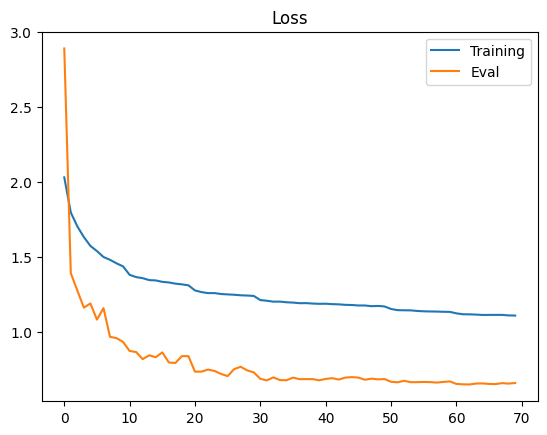

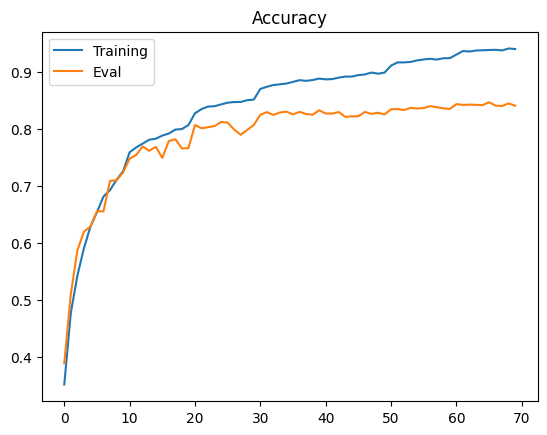

In [6]:
initial_lr = 0.05
w = 0.3
save_to_path = '/content/drive/MyDrive/thesis_pt_2/models/cifar-10-soft-classification'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = initial_lr, momentum = 0.9, weight_decay=5e-4)
scheduler = MultiStepLR(optimizer, milestones=[10, 20, 30, 50, 60], gamma=0.5)
sl_train_model(model, train_dataloader, num_epochs = 70, optimizer=optimizer, scheduler = scheduler,
               criterion=criterion,
               W=w, PATH=save_to_path, eval=True, eval_dataloader=test_dataloader, plot=True)

## Getting test-set embeddings

In [7]:
def get_test_embeddings(dnn_model, dataloader, batch_size):

  ret_embs = torch.zeros((10000, 512))
  ret_labs = torch.zeros(10000)
  acc = 0

  dnn_model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(dataloader):
      start_i = i*batch_size
      end_i = start_i+labels.size()[0]
      images=images.to(device)
      labels=labels.to(device)
      embeddings, outputs = dnn_model(images)
      preds = outputs.argmax(axis=1)
      ret_embs[start_i:end_i, :] = embeddings
      ret_labs[start_i:end_i] = labels
      acc += (preds==labels).sum()
  
  print('Accuracy:', acc/10000)
  
  return ret_embs, ret_labs


In [8]:
embeddings, labels = get_test_embeddings(model, test_dataloader, 256)

Accuracy: tensor(0.8411, device='cuda:0')


## MDS projections

In [9]:
np.random.seed(15)
indices = np.random.choice(np.arange(10000), size=1500, replace=False)
compl_embs = embeddings[indices,:].detach().cpu()

In [10]:
from sklearn.manifold import MDS
projs = MDS(random_state=15).fit_transform(compl_embs.detach().numpy())
x = projs[:,0]
y = projs[:,1]

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


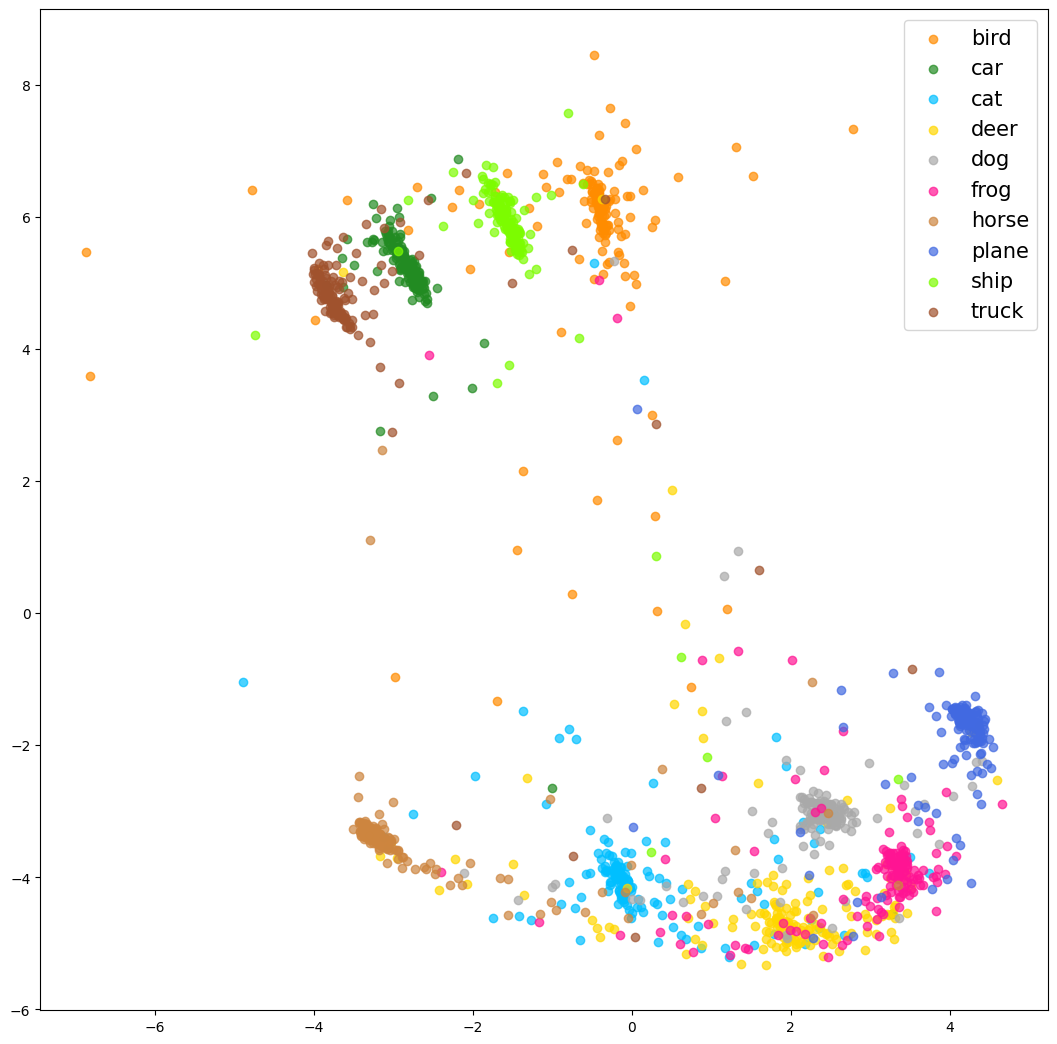

In [11]:
import matplotlib.pyplot as plt
labs = labels[indices]

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes.sort()
colors = ['darkorange','forestgreen','deepskyblue', 'gold','darkgray', 'deeppink',
            'peru','royalblue', 'lawngreen', 'sienna']
plt.figure(figsize=(13,13))
for i in range(10):
  plt.scatter(x[labs==i], y[labs==i], alpha=0.7, color=colors[i], label = classes[i])
plt.legend(fontsize=15)

plt.show()